# Permanent versus Persistent Income Shocks


In [1]:
# Initial imports and notebook setup
%matplotlib inline
import matplotlib.pyplot as plt

import sys
import os
from copy import copy
from HARK.utilities import plotFuncs
import numpy as np

In [2]:
from HARK.ConsumptionSaving.ConsGenIncProcessModel import *
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

`ConsIndShockModel` assumes that income has a permanent component $p$ which is subject to "permanent" shocks:

   $\log p_{t+1} = \log p_{t} + \log \psi_{t+1}$

Many papers in the literature instead examine models in which shocks merely have some persistence,

$\log p_{t+1} = \gamma \log p_{t} + \log \psi_{t+1}$

where if $0 < \gamma < 1$ then $\lim_{n \uparrow \infty} \mathbb{E}_{t}[\log p_{t+n}]=0$ (which means that the level of $p$ reverts to its mean of $p=1$.  The two models become identical as $\gamma$ approaches 1.

This notebook describes HARK's tools to solve models with persistent shocks.

1. `ConsGenIncProcessModel` extends `ConsIndShockModel` by explicitly tracking persistent income $p_t$ as a state variable.
1. `IndShockExplicitPermIncConsumerType` is a type of consumer created for comparison and for whom we know for sure that their income process is one in which $\gamma=1$



## General Income Process model
In  `ConsGenIncProcessModel` the user can define a generic function $G$ that translates current $p_{t}$ into expected next period persistent income $p_{t+1}$ (subject to shocks). 


The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(M_t,p_t) &=& \max_{c_t} U(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E}_{t} [v_{t+1}(M_{t+1}, p_{t+1})] \\
a_t &=& M_t - c_t \\
a_t &\geq& \underline{a} \\
M_{t+1} &=& R a_t + \theta_{t+1} \\
p_{t+1} &=& G_{t+1}(p_t)\psi_{t+1} \\
\psi_t \sim F_{\psi t} &\qquad&  \theta_t \sim F_{\theta t} \\
 \mathbb{E} [F_{\psi t}] = 1 & & \mathbb{E} [F_{\psi t}] =1 \\
U(c) &=& \frac{c^{1-\rho}}{1-\rho}
\end{eqnarray*}

The one-period problem for this model is solved by the function $\texttt{solveConsGenIncProcess}$, which creates an instance of the class $\texttt{ConsGenIncProcessSolver}$. The class $\texttt{GenIncProcessConsumerType}$ extends $\texttt{IndShockConsumerType}$ to represent agents in this model. To construct an instance of this class, several  parameters must be passed to the constructor, as shown in the table below (parameters can be either "primitive" or "constructed" if they have already built-in capabilities from previous models).

### Example parameter values to solve GenIncProcess model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\beta$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | 0.96 | |
| $\rho$ |Coefficient of relative risk aversion | $\texttt{CRRA}$ | 2.0 | |
| $R$ | Risk free interest factor | $\texttt{Rfree}$ | 1.03 | |
| $1 - \mathsf{D}$ |Survival probability | $\texttt{LivPrb}$ | [0.98] | |
| $\underline{a}$ |Artificial borrowing constraint | $\texttt{BoroCnstArt}$ | 0.0 | | 
| $(none)$ |Indicator of whether $\texttt{vFunc}$ should be computed | $\texttt{vFuncBool}$ | 'True' | |
| $(none)$ |Indicator of whether $\texttt{cFunc}$ should use cubic lines | $\texttt{CubicBool}$ | 'False' |  |
|$F$ |A list containing three arrays of floats, representing a discrete <br> approximation to the income process: <br>event probabilities, persistent shocks, transitory shocks | $\texttt{IncomeDstn}$ | - |$\surd$ |
| $G$ |Expected persistent income next period | $\texttt{pLvlNextFunc}$ | - | $\surd$ |
| $(none)$ |Array of time-varying persistent income levels | $\texttt{pLvlGrid}$ | - |$\surd$ |
| $(none)$ | Array of "extra" end-of-period asset values | $\texttt{aXtraGrid}$ | - |$\surd$ |

### Constructed inputs to solve GenIncProcess
The "constructed" inputs above are using expected attributes and are drawn on various methods as explained below.


* The input $\texttt{IncomeDstn}$ is created by the method $\texttt{updateIncomeProcess}$ which inherits from $\texttt{IndShockConsumerType}$. (*hyperlink to that noteboook*)

* The input $\texttt{pLvlNextFunc}$ is created by the method $\texttt{updatepLvlNextFunc}$ which uses the initial sequence of $\texttt{pLvlNextFunc}$, the mean and standard deviation of the (log) initial permanent income, $\texttt{pLvlInitMean}$ and $\texttt{pLvlInitStd}$. 
In this model, the method creates a trivial $\texttt{pLvlNextFunc}$ attribute with no persistent income dynamics.  But we can overwrite it by subclasses in order to make an AR1 income process for example. 


* The input $\texttt{pLvlGrid}$ is created by the method $\texttt{updatepLvlGrid}$ which updates the grid of persistent income levels for infinite horizon models (cycles=0) and lifecycle models (cycles=1). This method draws on the initial distribution of persistent income, the $\texttt{pLvlNextFuncs}$, $\texttt{pLvlInitMean}$, $\texttt{pLvlInitStd}$ and the attribute $\texttt{pLvlPctiles}$ (percentiles of the distribution of persistent income). It then uses a simulation approach to generate the $\texttt{pLvlGrid}$ at each period of the cycle.


* The input $\texttt{aXtraGrid}$ is created by $\texttt{updateAssetsGrid}$ which updates the agent's end-of-period assets grid by constructing a multi-exponentially spaced grid of aXtra values, based on $\texttt{aNrmInitMean}$ and $\texttt{aNrmInitStd}$. 


## 1. Consumer with Explicit Permanent Income

Let's make an example of our generic model above with an "explicit permanent income" consumer who experiences idiosyncratic shocks to permanent and transitory, and faces permanent income growth.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(M_t,p_t) &=& \max_{c_t} U(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [v_{t+1}(M_{t+1}, p_{t+1}) ], \\
a_t &=& M_t - c_t, \\
a_t &\geq& \underline{a}, \\
M_{t+1} &=& R/(\Gamma_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
p_{t+1} &=& G_{t+1}(p_t)\psi_{t+1}, \\
\psi \sim F_{\psi}, \mathbb{E} [F_{\psi t}] = 1 &\qquad&  \theta_t \sim F_{\theta}, \mathbb{E} [F_{\psi}] = 1, \\
U(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}


This agent type is identical to an $\texttt{IndShockConsumerType}$ but for explicitly tracking $\texttt{pLvl}$ as a state variable during solution as shown in the mathematical representation of GenIncProcess model. 

To construct $\texttt{IndShockExplicitPermIncConsumerType}$ as an instance of $\texttt{GenIncProcessConsumerType}$, we need to pass additional parameters to the constructor as shown in the table below.

### Additional parameters to solve ExplicitPermInc model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
|(none)|percentiles of the distribution of persistent income|$\texttt{pLvlPctiles}$|||
| $G$ |Expected persistent income next period | $\texttt{pLvlNextFunc}$ | - | $\surd$ |
|$\Gamma$|Permanent income growth factor|$\texttt{PermGroFac}$|[1.0]| |


### Constructed inputs to solve ExplicitPermInc

* In this "explicit permanent income" model, we overwrite the method $\texttt{updatepLvlNextFunc}$ to create $\texttt{pLvlNextFunc}$ as a sequence of linear functions, indicating constant expected permanent income growth across permanent income levels.  This method uses the attribute $\texttt{PermGroFac}$, and installs a special retirement function when it exists.



In [3]:
# This cell defines a dictionary to make an instance of "explicit permanent income" consumer.
GenIncDictionary = { 
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "AgentCount" : 10000,                  # Number of agents of this type (only matters for simulation)
    "aNrmInitMean" : 0.0,                  # Mean of log initial assets (only matters for simulation)
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets (only for simulation)
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income (only matters for simulation)
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income (only matters for simulation)
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor (only matters for simulation)
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type
# Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 30,                       # Maximum end-of-period "assets above minimum" value               
    "aXtraExtra" : [0.005,0.01],           # Some other value of "assets above minimum" to add to the grid
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraCount" : 48,                     # Number of points in the grid of "assets above minimum"
# Parameters describing the income process
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "PermShkStd" : [0.1],                  # Standard deviation of log permanent income shocks
    "TranShkStd" : [0.1],                  # Standard deviation of log transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "UnempPrbRet" : 0.005,                 # Probability of "unemployment" while retired
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "tax_rate" : 0.0,                      # Flat income tax rate
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "BoroCnstArt" : 0.0,                  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "CubicBool" : False,                  # Use cubic spline interpolation when True, linear interpolation when False
    "vFuncBool" : True,                   # Whether to calculate the value function during solution    
# More parameters specific to "Explicit Permanent income" shock model
    "cycles": 0,
    "pLvlPctiles" : np.concatenate(([0.001, 0.005, 0.01, 0.03], np.linspace(0.05, 0.95, num=19),[0.97, 0.99, 0.995, 0.999])),
    "PermGroFac" : [1.0],                  # Permanent income growth factor - long run permanent income growth doesn't work yet    
}

Let's now create an instance of the type of consumer we are interested in and solve this agent's problem with an infinite horizon (cycles=0).

In [4]:
# Make and solve an example "explicit permanent income" consumer with idiosyncratic shocks
ExplicitExample = IndShockExplicitPermIncConsumerType(**GenIncDictionary)
                                        
print('Here, the lowest percentile is ' + str(GenIncDictionary['pLvlPctiles'][0]*100))
print('and the highest percentile is ' + str(GenIncDictionary['pLvlPctiles'][-1]*100) + '.\n')
      
ExplicitExample.solve()

Here, the lowest percentile is 0.1
and the highest percentile is 99.9.



In the cell below, we generate a plot of the consumption function for explicit permanent income consumer at different income levels.

Consumption function by pLvl for explicit permanent income consumer:


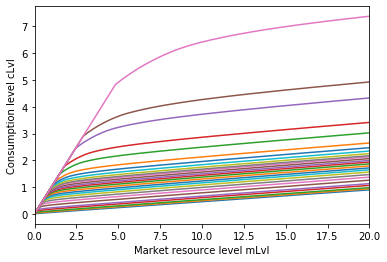

In [5]:
# Plot the consumption function at various permanent income levels.
print('Consumption function by pLvl for explicit permanent income consumer:')
pLvlGrid = ExplicitExample.pLvlGrid[0]
mLvlGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mLvlGrid + ExplicitExample.solution[0].mLvlMin(p)
    C = ExplicitExample.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp,C)
plt.xlim(0.,20.)
plt.xlabel('Market resource level mLvl')
plt.ylabel('Consumption level cLvl')
plt.show()

## Permanent income normalized

An alternative model is to normalize it by dividing all variables by permanent income $p_t$ and solve the model again.

In [6]:
# Make and solve an example of normalized model
NormalizedExample = IndShockConsumerType(**GenIncDictionary)
NormalizedExample.solve()


The given parameter values violate the Individual Growth Impatience Condition; the GIFInd is: 1.0037 



Normalized consumption function by pLvl for explicit permanent income consumer:


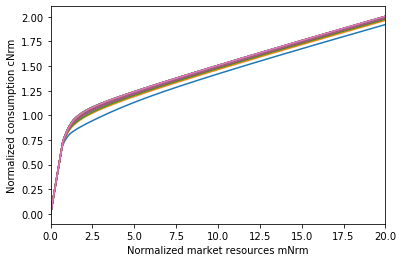

Consumption function for normalized problem (without explicit permanent income):


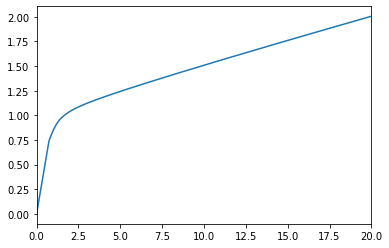

In [7]:
# Compare the normalized problem with and without explicit permanent income and plot the consumption functions
print('Normalized consumption function by pLvl for explicit permanent income consumer:')
pLvlGrid = ExplicitExample.pLvlGrid[0]
mNrmGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mNrmGrid*p + ExplicitExample.solution[0].mLvlMin(p)
    C = ExplicitExample.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp/p,C/p)

plt.xlim(0.,20.)
plt.xlabel('Normalized market resources mNrm')
plt.ylabel('Normalized consumption cNrm')
plt.show()

print('Consumption function for normalized problem (without explicit permanent income):')
mNrmMin = NormalizedExample.solution[0].mNrmMin
plotFuncs(NormalizedExample.solution[0].cFunc,mNrmMin,mNrmMin+20.)

The figures above show that the normalized consumption function for the "explicit permanent income" consumer is almost identical for every permanent income level (and the same as the normalized problem's $\texttt{cFunc}$), but is less accurate due to extrapolation outside the bounds of $\texttt{pLvlGrid}$. 

The "explicit permanent income" solution deviates from the solution to the normalized problem because of errors from extrapolating beyond the bounds of the $\texttt{pLvlGrid}$. The error is largest for $\texttt{pLvl}$ values near the upper and lower bounds, and propagates toward the center of the distribution.


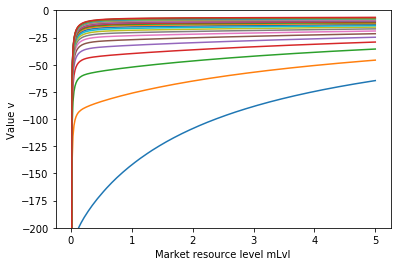

In [8]:
# Plot the value function at various permanent income levels
if ExplicitExample.vFuncBool:
    pGrid = np.linspace(0.1,3.0,24)
    M = np.linspace(0.001,5,300)
    for p in pGrid:
        M_temp = M+ExplicitExample.solution[0].mLvlMin(p)
        C = ExplicitExample.solution[0].vFunc(M_temp,p*np.ones_like(M_temp))
        plt.plot(M_temp,C)
    plt.ylim([-200,0])
    plt.xlabel('Market resource level mLvl')
    plt.ylabel('Value v')
    plt.show()

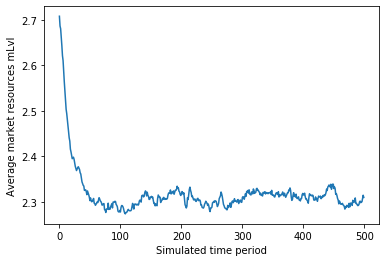

In [9]:
# Simulate many periods to get to the stationary distribution
ExplicitExample.T_sim = 500
ExplicitExample.track_vars = ['mLvlNow','cLvlNow','pLvlNow']
ExplicitExample.initializeSim()
ExplicitExample.simulate()
plt.plot(np.mean(ExplicitExample.mLvlNow_hist,axis=1))
plt.xlabel('Simulated time period')
plt.ylabel('Average market resources mLvl')
plt.show()

## 2. Persistent income shock consumer


Class to solve consumption-saving models with idiosyncratic shocks to income in which shocks are persistent and transitory. This model extends $\texttt{ConsGenIndShockModel}$ by allowing (log) persistent income to follow an AR(1) process.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(M_t,p_t) &=& \max_{c_t} U(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [v_{t+1}(M_{t+1}, p_{t+1}) ], \\
a_t &=& M_t - c_t, \\
a_t &\geq& \underline{a}, \\
M_{t+1} &=& R a_t + \theta_{t+1}, \\
log(p_{t+1}) &=& \varphi log(p_t)+(1-\varphi log(\overline{p}_{t+1} ) +log(\Gamma_{t+1})+log(\psi_{t+1}), \\
\\
\psi_t \sim F_{\psi t} &\qquad&  \theta_t \sim F_{\theta t}, \mathbb{E} [F_{\psi t}] = 1 \\
\end{eqnarray*}

### Additional parameters to solve PersistentShock model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
|$\varphi$|Serial correlation coefficient for permanent income|$\texttt{PrstIncCorr}$|0.98||
||||||

### Constructed inputs to solve PersistentShock

* For this model, we overwrite the method $\texttt{updatepLvlNextFunc}$ to create the input $\texttt{pLvlNextFunc}$ as a sequence of AR1-style functions. The method uses now the attributes $\texttt{PermGroFac}$ and $\texttt{PrstIncCorr}$. If cycles=0, the product of $\texttt{PermGroFac}$ across all periods must be 1.0, otherwise this method is invalid.


In [10]:
# Make a dictionary for the "persistent idiosyncratic shocks" model
PrstIncCorr = 0.98       # Serial correlation coefficient for persistent income

persistent_shocks = copy(GenIncDictionary)
persistent_shocks['PrstIncCorr'] = PrstIncCorr

The $\texttt{PersistentShockConsumerType}$ class solves the problem of a consumer facing idiosyncratic shocks to his persistent and transitory income, and for which the (log) persistent income follows an AR1 process rather than random walk.

In [11]:
# Make and solve an example of "persistent idisyncratic shocks" consumer
PersistentExample = PersistentShockConsumerType(**persistent_shocks)
PersistentExample.solve()

Consumption function by persistent income level pLvl for a consumer with AR1 coefficient of 0.98:


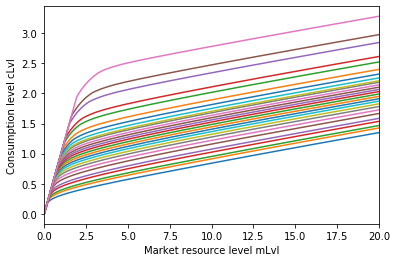

In [12]:
# Plot the consumption function at various levels of persistent income pLvl
print('Consumption function by persistent income level pLvl for a consumer with AR1 coefficient of ' + str(PersistentExample.PrstIncCorr) + ':')
pLvlGrid = PersistentExample.pLvlGrid[0]
mLvlGrid = np.linspace(0,20,300)
for p in pLvlGrid:
    M_temp = mLvlGrid + PersistentExample.solution[0].mLvlMin(p)
    C = PersistentExample.solution[0].cFunc(M_temp,p*np.ones_like(M_temp))
    plt.plot(M_temp,C)
plt.xlim(0.,20.)
plt.xlabel('Market resource level mLvl')
plt.ylabel('Consumption level cLvl')
plt.show()

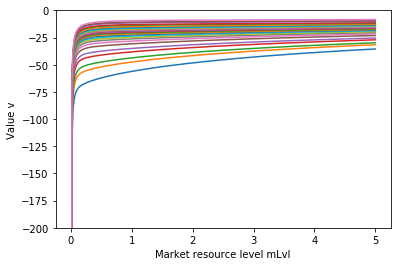

In [13]:
# Plot the value function at various persistent income levels
if PersistentExample.vFuncBool:
    pGrid = PersistentExample.pLvlGrid[0]
    M = np.linspace(0.001,5,300)
    for p in pGrid:
        M_temp = M+PersistentExample.solution[0].mLvlMin(p)
        C = PersistentExample.solution[0].vFunc(M_temp,p*np.ones_like(M_temp))
        plt.plot(M_temp,C)
    plt.ylim([-200,0])
    plt.xlabel('Market resource level mLvl')
    plt.ylabel('Value v')
    plt.show()

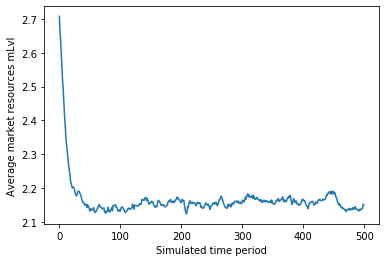

In [14]:
# Simulate some data
PersistentExample.T_sim = 500
PersistentExample.track_vars = ['mLvlNow','cLvlNow','pLvlNow']
PersistentExample.initializeSim()
PersistentExample.simulate()
plt.plot(np.mean(PersistentExample.mLvlNow_hist,axis=1))
plt.xlabel('Simulated time period')
plt.ylabel('Average market resources mLvl')
plt.show()